# Cdc2 Cyclin Model
Drew Willis

Source:</br>
Tyson, J. J. “Modeling the Cell Division Cycle: Cdc2 and Cyclin Interactions.” 
Proceedings of the National Academy of Sciences, vol. 88, no. 16, 1991, pp. 7328–7332., doi:10.1073/pnas.88.16.7328.


In [1]:
import tellurium as te
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
from ipywidgets import *
from IPython.display import display, update_display

This is a recreation cdc2 cyclin model described in Tyson's paper.

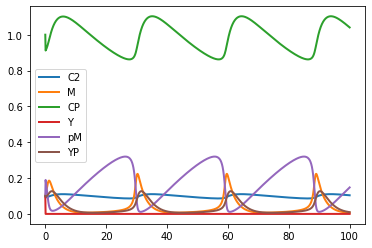

In [2]:
model = '''
    // Equations
    C2' = k6*M - k8*P*C2 + k9*CP
    CP' = -k3*CP*Y + k8*P*C2 - k9*CP
    pM' = k3*CP*Y - pM*(k4p + k4*(M/CT)^2) + k5*P*M
    M' = pM*(k4p + k4*(M/CT)^2) - k5*P*M - k6*M
    Y' = k1*aa - k2*Y - k3*CP*Y
    YP' = k6*M - k7*YP
    CT := C2+CP+pM+M
    
    // Inputs
    k1 := 0.015*CT/aa
    k2 = 0
    k3 := 200/CT
    k4 = 100
    k4p = 0.018
    k5 = 0
    k6 = 0.5
    k7 = 0.6
    k8 = 100
    k9 = 10
    P = 1
    aa = 1
    
    C2 = 0.1
    CP = 1
    pM = 0.1
    M = 0.1
    Y = 0.1
    YP = 0.1
    

'''

m = te.loada(model)
s = m.simulate(0,100,1000)
m.plot()

Alternate model representation

k1 rate constant cyclin production
k2 rate constant....


* aa  : amino acids 
* C2  : cdc2
* CP  : cdc2-P
* pM  : P-cyclin-cdc2-P / preMPF
* M   : P-cyclin-cdc2   / active MPF
* Y   : cyclin
* CP  : cyclin-P
* CT  : total cdc2
* k4 > k4p

Small k6, steady state high MPF activity (metaphase arrest of unfertilized eggs)

Moderate k6, autonomous oscillations (rapid cell cycling in early embryos)

Large k6, excitable steady state low MPF activity (interphase arrest of resting somatic cells)

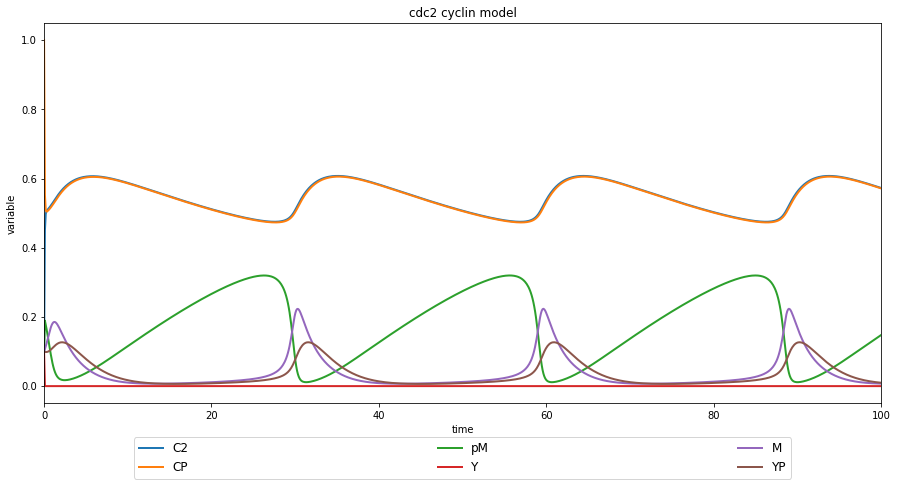

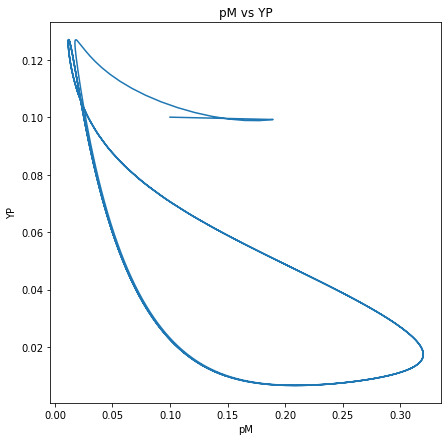

In [28]:
# ----< DEFINE MODEL >----
model = '''
    // Equations
    E1: C2 -> CP ; k8*P*C2
    E2: CP -> C2 ; k9*CP
    E3: CP -> pM ; k3*CP*Y
    E4: pM -> M ; pM * (k4p + k4*(M/CT)^2)
    E5: M -> pM ; k5*P*M
    E6: M -> C2 ; k6*M
    E7:   -> Y ; k1*aa
    E8: Y ->   ; k2*Y
    E9: Y ->   ; k3*CP*Y
    E10:    -> YP ; k6*M
    E11: YP ->    ; k7*YP
    
    
    CT := C2+CP+pM+M
    
    // Inputs
    k1 := 0.015*CT/aa
    k2 = 0
    k3 := 200/CT
    k4 = 100
    k4p = 0.018
    k5 = 0
    k6 = 0.5
    k7 = 0.6
    k8 = 100
    k9 = 10
    P = 1
    aa = 1
    
    C2 = 0.1
    CP = 1
    pM = 0.1
    M = 0.1
    Y = 0.1
    YP = 0.1
    

'''

    
# ----< WIDGETS >----

# model parameters
style = {'description_width': 'initial'}
k4_widget = widgets.FloatSlider(
    description='k4 rate constant',
    value=100.0,
    min=10.0,
    max=1000.0,
    continuous_update=False,
    style=style
)
k6_widget = widgets.FloatSlider(
    description='k6 rate constant',
    value=0.5,
    min=0.1,
    max=10.0,
    continuous_update=False,
    style=style
)

k8_widget = widgets.FloatSlider(
    description='k8 rate constant',
    value=0.5,
    min=10.0,
    max=200.0,
    continuous_update=False,
    style=style
)

k9_widget = widgets.FloatSlider(
    description='k9 rate constant',
    value=10.0,
    min=10.0,
    max=200.0,
    continuous_update=False,
    style=style
)

# simulation settings
sim_length_widget = widgets.IntSlider(
    description='simulation length',
    value=100,
    min=2,
    max=1000,
    continuous_update=False,
    style=style
)
sim_points_widget = widgets.IntSlider(
    description='simulated points',
    value=1000,
    min=2,
    max=20000,
    continuous_update=False,
    style=style
)


# display toggles
C2_widget = widgets.ToggleButton(
    description='C2 toggle',
    value=True,
)
CP_widget = widgets.ToggleButton(
    description='CP toggle',
    value=True,
)
pM_widget = widgets.ToggleButton(
    description='pM toggle',
    value=True,
)
Y_widget = widgets.ToggleButton(
    description='Y toggle',
    value=True,
)
M_widget = widgets.ToggleButton(
    description='M toggle',
    value=True,
)
YP_widget = widgets.ToggleButton(
    description='YP toggle',
    value=True,
)
yscale_widget = widgets.ToggleButton(
    description='yscale: linear',
    value=False
)

center_align = widgets.Layout(display='justify-content',
                flex_flow='column',
                align_items='stretch',
                width='100%')
right_align = widgets.Layout(display='flex',
                flex_flow='column',
                align_items='flex-end',
                width='100%')
left_vbox = widgets.VBox([k4_widget,k6_widget,k8_widget,k9_widget])
right_vbox = widgets.VBox([sim_length_widget,sim_points_widget])
simulation_hbox = widgets.HBox([left_vbox,right_vbox],layout=center_align)
yscale_hbox = widgets.HBox([yscale_widget], layout=right_align)
display_toggles_hbox = widgets.HBox([C2_widget,CP_widget,pM_widget,Y_widget,M_widget,YP_widget],layout=center_align)


# ----< PLOT SETUP >----

fig, axs = plt.subplots(1,figsize=(15,7))
plt.close()
fig2, axs2 = plt.subplots(1, figsize=(7,7))
axs.set(title='cdc2 cyclin model',xlabel='time',ylabel='variable')
axs2.set(title='pM vs YP',xlabel='pM',ylabel='YP')
plt.close()


# ----< INTERACT AND RUN >----

def RunModel(*args):
    # reload model in case user interacts with other cells and touches these widgets
    m = te.loada(model) 
    

    m.k4 = k4_widget.value
    m.k6 = k6_widget.value
    m.k8 = k8_widget.value
    m.k9 = k9_widget.value
    s = m.simulate(0,sim_length_widget.value,sim_points_widget.value,['time','C2','CP','pM','Y','M','YP'])
    
    axs.set(xlim=[0,sim_length_widget.value])
    linewidth = 2
    if C2_widget.value:
        axs.plot(s['time'],s['C2'],linewidth=linewidth,label='C2')
    if CP_widget.value:
        axs.plot(s['time'],s['CP'],linewidth=linewidth,label='CP')
    if pM_widget.value:
        axs.plot(s['time'],s['pM'],linewidth=linewidth,label='pM')
    if Y_widget.value:
        axs.plot(s['time'],s['Y'],linewidth=linewidth,label='Y')
    if M_widget.value:
        axs.plot(s['time'],s['M'],linewidth=linewidth,label='M')
    if YP_widget.value:
        axs.plot(s['time'],s['YP'],linewidth=linewidth,label='YP')
    if axs.lines:
        axs.legend(bbox_to_anchor=(0.1, -0.175, 0.8, .102), loc=2, ncol=3, mode="expand",fontsize='large')
    axs2.plot(s['pM'],s['YP'])
    update_display(display_id="0", obj=fig)
    update_display(display_id="1", obj=fig2)
    axs.cla()
    axs2.cla()

for i in range(len(left_vbox.children)):
    left_vbox.children[i].observe(RunModel,names='value')
for i in range(len(right_vbox.children)):
    right_vbox.children[i].observe(RunModel,names='value')
for i in range(len(display_toggles_hbox.children)):
    display_toggles_hbox.children[i].observe(RunModel,names='value')
display(fig, display_id="0")
display(simulation_hbox)
display(display_toggles_hbox)
display(yscale_hbox)
display(fig2, display_id="1")

RunModel()

### Parameter Scan
2d parameter scan k4 and k6 to find when oscillations occur

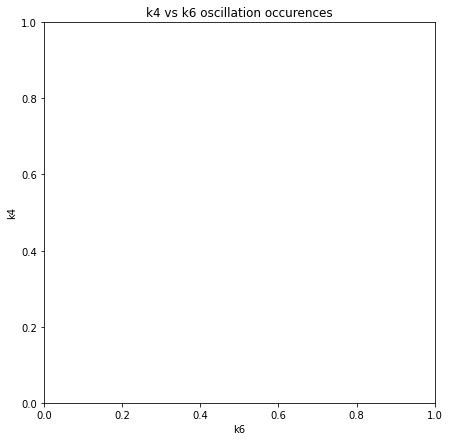

In [4]:
# ----< DEFINE MODEL >----
model = '''
    // Equations
    E1: C2 -> CP ; k8*P*C2
    E2: CP -> C2 ; k9*CP
    E3: CP -> pM ; k3*CP*Y
    E4: pM -> M ; pM * (k4p + k4*(M/CT)^2)
    E5: M -> pM ; k5*P*M
    E6: M -> C2 ; k6*M
    E7:   -> Y ; k1*aa
    E8: Y ->   ; k2*Y
    E9: Y ->   ; k3*CP*Y
    E10:    -> YP ; k6*M
    E11: YP ->    ; k7*YP
    
    
    CT := C2+CP+pM+M
    
    // Inputs
    k1 := 0.015*CT/aa
    k2 = 0
    k3 := 200/CT
    k4 = 100
    k4p = 0.018
    k5 = 0
    k6 = 0.5
    k7 = 0.6
    k8 = 100
    k9 = 10
    P = 1
    aa = 1
    
    C2 = 0.1
    CP = 1
    pM = 0.1
    M = 0.1
    Y = 0.1
    YP = 0.1
    

'''

    
# ----< WIDGETS >----

# model parameters
style = {'description_width': 'initial'}

k8_widget = widgets.FloatSlider(
    description='k8 rate constant',
    value=0.5,
    min=100.0,
    max=200.0,
    continuous_update=False,
    style=style
)

k9_widget = widgets.FloatSlider(
    description='k9 rate constant',
    value=10.0,
    min=10.0,
    max=200.0,
    continuous_update=False,
    style=style
)

# simulation settings
sim_length_widget = widgets.IntSlider(
    description='simulation length',
    value=250,
    min=2,
    max=1000,
    continuous_update=False,
    style=style
)
sim_points_widget = widgets.IntSlider(
    description='simulated points',
    value=500,
    min=2,
    max=20000,
    continuous_update=False,
    style=style
)


left_vbox = widgets.VBox([k8_widget,k9_widget])
right_vbox = widgets.VBox([sim_length_widget,sim_points_widget])
simulation_hbox = widgets.HBox([left_vbox,right_vbox])


# ----< PLOT SETUP >----

fig, axs = plt.subplots(1,figsize=(7,7))
axs.set(title='k4 vs k6 oscillation occurences',xlabel='k6',ylabel='k4')
plt.close()


# ----< INTERACT AND RUN >----
def GetState(s):
    oscillations=0
    flip=False
    highYP=0
    highpM=0
    for i in range(int(len(s)/2),len(s['pM'])):
        if flip:
            highYP+=1
            if s['pM'][i]>s['YP'][i]+0.1:
                oscillations += 1
                flip=False
        else:
            highpM+=1
            if s['pM'][i]<s['YP'][i]+0.1:
                oscillations += 1
                flip=True
    if oscillations>7:
        return "green"
    else:
        if highYP>highpM:
            return "red"
        else:
            return "orange"
    
            
        
    
def RunModel(*args):
    # reload model in case user interacts with other cells and touches these widgets
    m = te.loada(model) 
    x=[]
    y=[]
    color=[]
    for lk4 in np.arange(1.0,3.0,0.1):
        for lk6 in np.arange(-1.0,1.0,0.1):
            m.resetAll()
            m.k4 = 10**lk4
            m.k6 = 10**lk6
            m.k8 = k8_widget.value
            m.k9 = k9_widget.value
            s = m.simulate(0,sim_length_widget.value,sim_points_widget.value,['time','C2','CP','pM','Y','M','YP'])
            state = GetState(s)
            x.append(10**lk6)
            y.append(10**lk4)
            color.append(state)
    axs.scatter(x=x,y=y,color=color,label=color)
    axs.set(yscale='log',xscale='log')
    
    axs.legend(bbox_to_anchor=(0.1, -0.175, 0.8, .102), loc=2, ncol=3, mode="expand",fontsize='large')
    #axs.set(xlim=[0,10],ylim=[10,20])
    update_display(display_id="2", obj=fig)
    
    axs.lines=[]
    axs.cla()

for i in range(len(left_vbox.children)):
    left_vbox.children[i].observe(RunModel,names='value')
for i in range(len(right_vbox.children)):
    right_vbox.children[i].observe(RunModel,names='value')
display(fig, display_id="2")
display(simulation_hbox)
